In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import os
import matplotlib.pyplot as plt

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

fase = '02b_DTW'

In [2]:
with open('gen_config.json', 'r') as file:
    gen_config =json.load(file)

In [3]:
folder = gen_config['folder']

path_norm = gen_config['path_norm']
path_dtw = gen_config['path_dtw']
clusters = gen_config['var_clusters']
ejecutar_dtw = gen_config['var_ejecutar_dtw']
dibujar_dtw = gen_config['var_dibujar_dtw']

print(f"{'COMIENZA':-^100}")
print(f"{fase:-^100}")

----------------------------------------------COMIENZA----------------------------------------------
----------------------------------------------02b_DTW-----------------------------------------------


In [4]:
df_norm = pd.read_parquet(f"{folder}/{path_norm}")

In [5]:
df_norm.sort_values(by=['product_id', 'customer_id','periodo'], inplace=True)

In [85]:
productos = df_norm['product_id', 'customer_id'].unique()
series = []
for producto in productos:
    series.append(df_norm[df_norm["product_id"] == producto][['tn_norm']])

In [86]:
X_train = to_time_series_dataset(series)

In [87]:
if ejecutar_dtw:
    x_clusters_dtw = np.full((X_train.shape[0], len(clusters)), np.nan)
    model_dtw = []

    for i in range(len(clusters)):
        start_time = datetime.now()
        model = TimeSeriesKMeans(n_clusters=clusters[i], metric="dtw",
                                max_iter=100, random_state=42, max_iter_barycenter=100,
                                n_jobs = -1)
        x_clusters_dtw[:,i] = model.fit_predict(X_train)
        print(f"DTW Corrida {i}, clusters: {model.n_clusters}, inertia: {model.inertia_:.2f}, time: {(datetime.now()-start_time).total_seconds():.2f}")
        model_dtw.append(model)

In [88]:
if ejecutar_dtw:
    x_clusters_softdtw = np.full((X_train.shape[0], len(clusters)), np.nan)
    model_softdtw = []

    for i in range(len(clusters)):
        start_time = datetime.now()
        model = TimeSeriesKMeans(n_clusters=clusters[i], metric="softdtw",
                                max_iter=100, random_state=42, max_iter_barycenter=100,
                                n_jobs = -1)
        x_clusters_softdtw[:,i] = model.fit_predict(X_train)
        print(f"Soft DTW Corrida {i}, clusters: {model.n_clusters}, inertia: {model.inertia_:.2f}, time: {(datetime.now()-start_time).total_seconds():.2f}")
        model_softdtw.append(model)

In [89]:
# x_clusters_dtw = np.full((X_train.shape[0], len(clusters)), np.nan)

# for i in range(len(clusters)):
#     x_clusters_dtw[:,i] = model_dtw[i].predict(X_train)

# x_clusters_softdtw = np.full((X_train.shape[0], len(clusters)), np.nan)

# for i in range(len(clusters)):
#     x_clusters_softdtw[:,i] = model_softdtw[i].predict(X_train)

In [90]:
if ejecutar_dtw:
    df_clusters = pd.concat([pd.DataFrame(productos), pd.DataFrame(x_clusters_dtw), pd.DataFrame(x_clusters_softdtw)], axis=1)
    cols = ['product_id']
    for method in ['cluster_dtw','cluster_softdtw']:
        for cluster in clusters:
            cols.append(f"{method}_{cluster:0>2}")

    df_clusters.columns = cols
    df_clusters.to_parquet(f"{folder}/{path_dtw}", index=False)

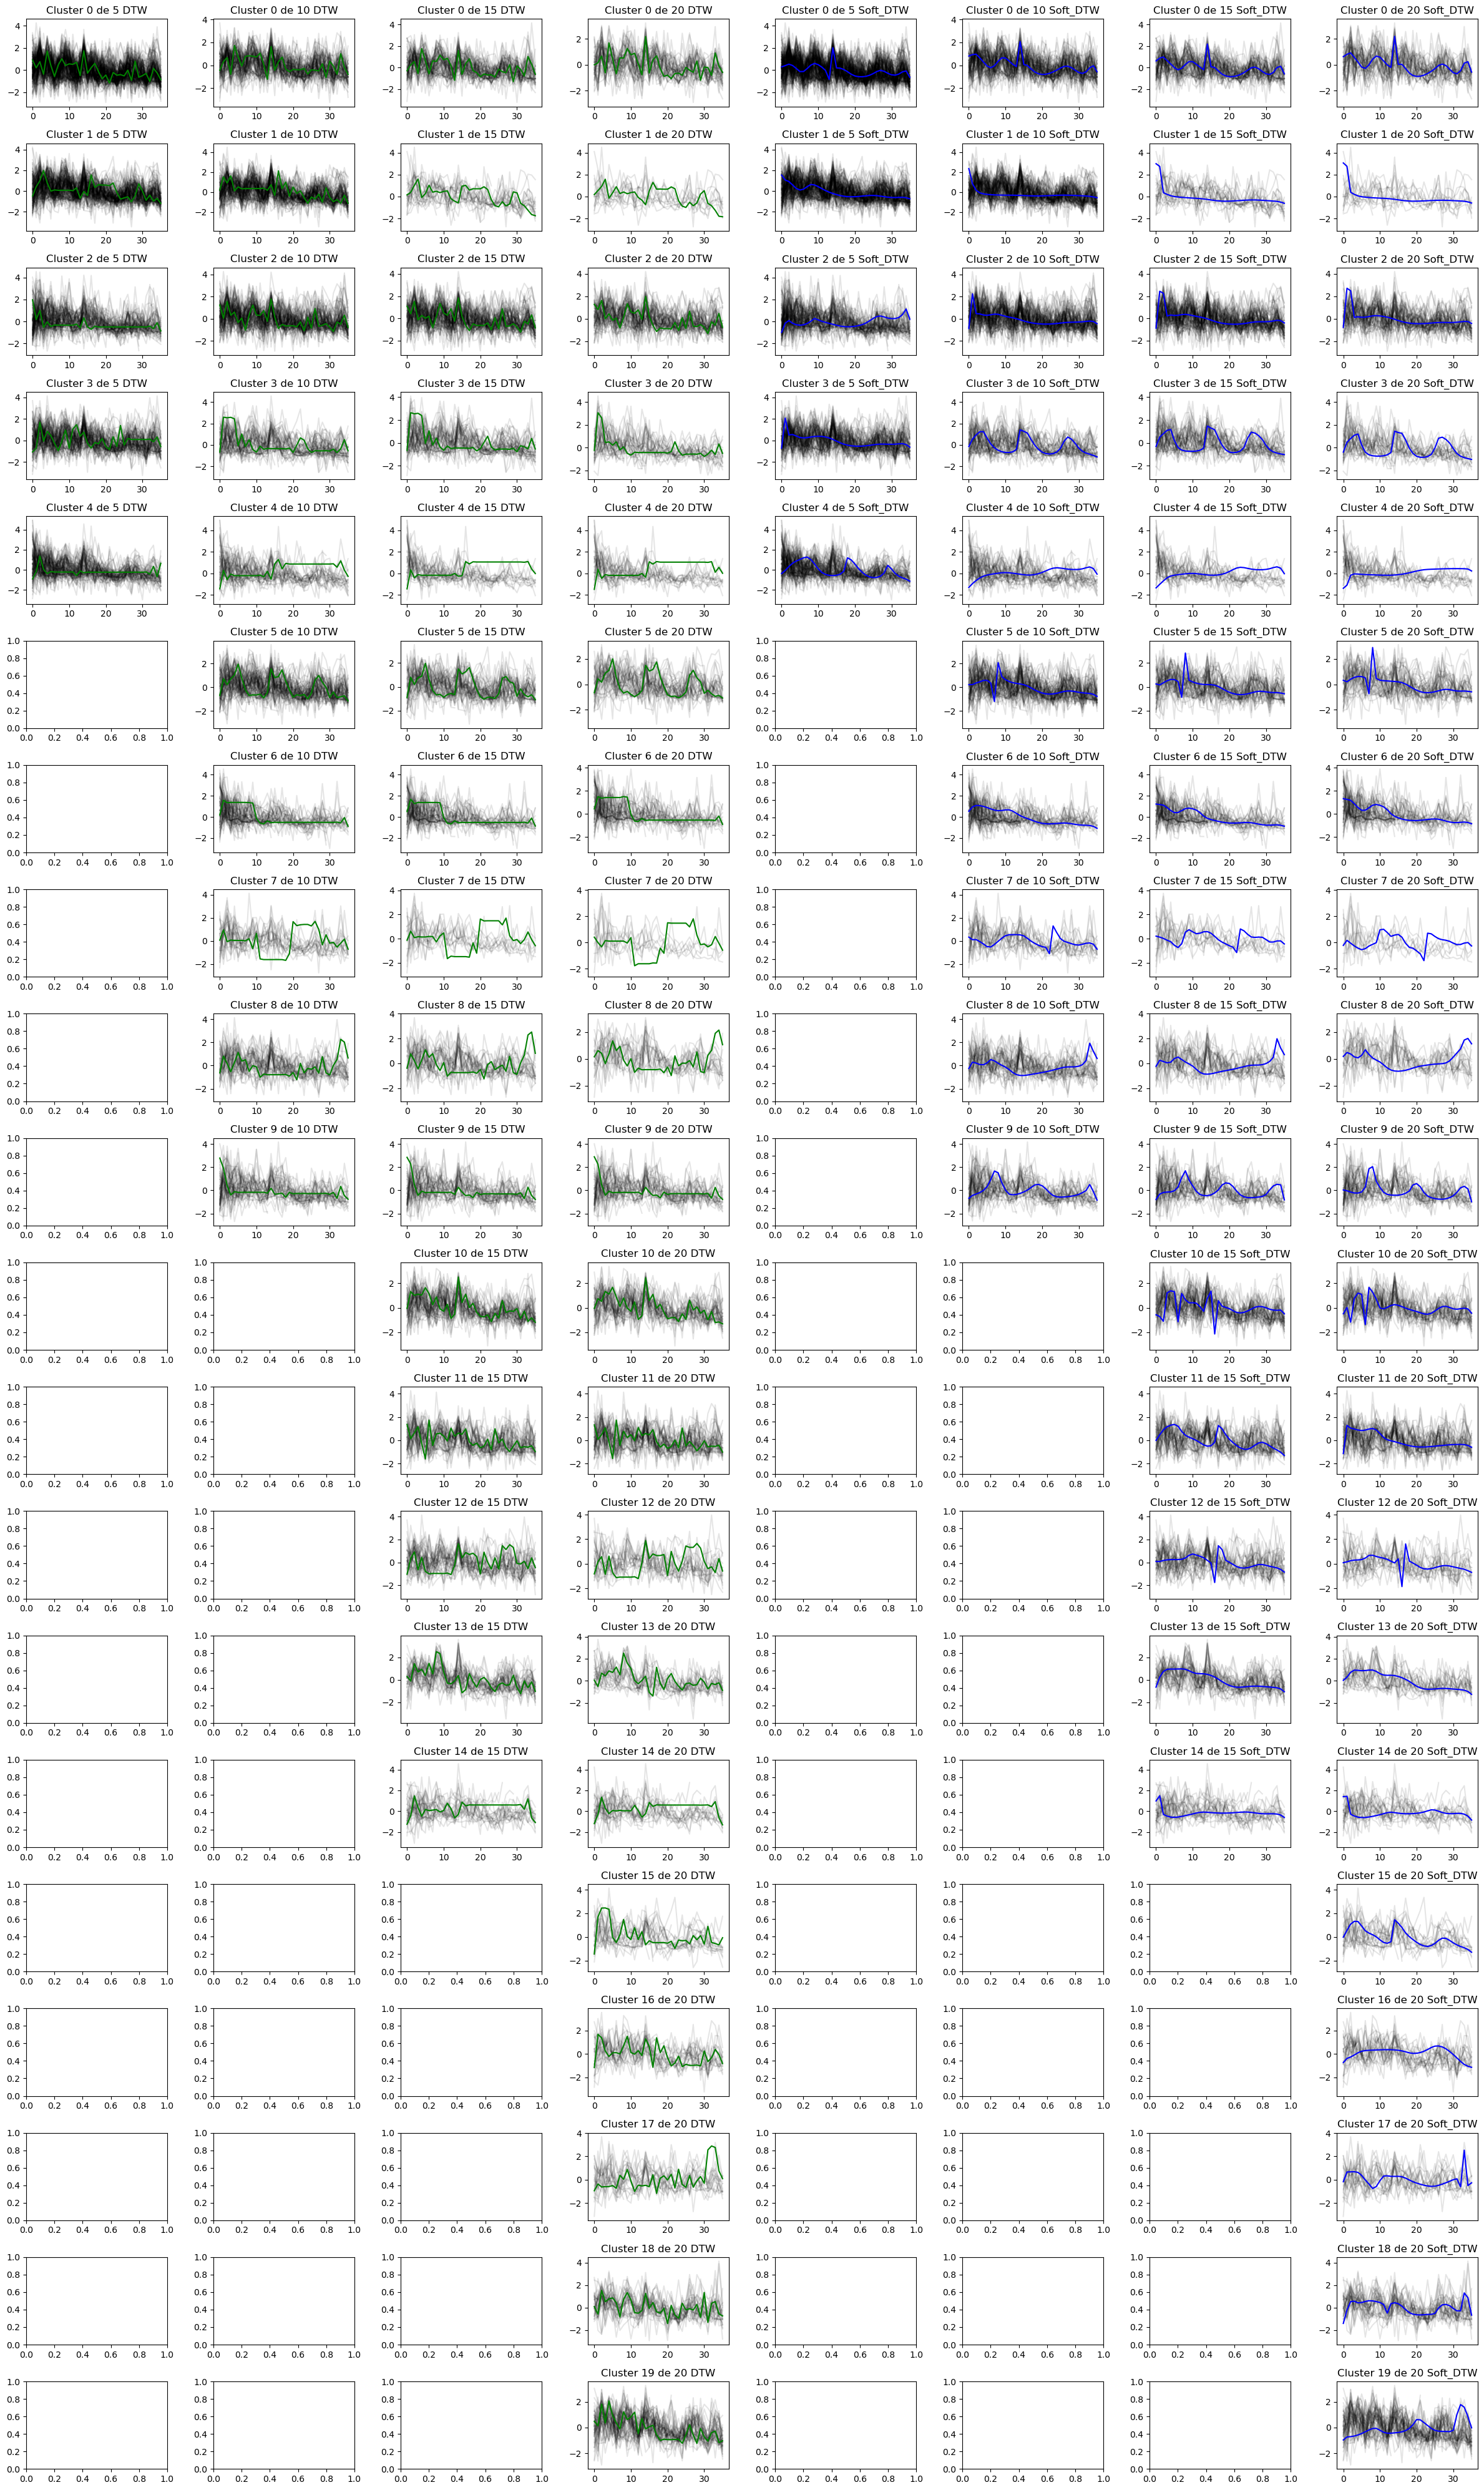

In [93]:
if dibujar_dtw:
    fig, axs = plt.subplots(max(clusters), len(clusters)*2, figsize=(24, 40))

    for i in range(len(clusters)):
        y_pred = x_clusters_dtw[:,i]

        for j in range(clusters[i]):
            for xx in X_train[y_pred == j]:
                axs[j, i].plot(xx.ravel(), "k-", alpha=.1)
            axs[j, i].plot(model_dtw[i].cluster_centers_[j].ravel(), color='green')
            axs[j, i].set_title(f"Cluster {j} de {clusters[i]} DTW")
            
            for xx in X_train[y_pred == j]:
                axs[j, (i+4)].plot(xx.ravel(), "k-", alpha=.1)
            axs[j, (i+4)].plot(model_softdtw[i].cluster_centers_[j].ravel(), color='blue')
            axs[j, (i+4)].set_title(f"Cluster {j} de {clusters[i]} Soft_DTW")

    plt.tight_layout()

    plt.show()

In [94]:
print(f"{fase:-^100}")
print(f"{'FINALIZA':-^100}\n\n\n")

----------------------------------------------02b_DTW-----------------------------------------------
----------------------------------------------FINALIZA----------------------------------------------

